In [29]:
# load some standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pysindy as ps
import sympy as sp
import os
import csv
import math #math fun
import matplotlib.pyplot as plt #plotting
import matplotlib.gridspec as gridspec

# os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.0" # use for running on Windows machine, change path as needed
import rpy2

import rpy2.robjects as robjects
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.filterwarnings("ignore", category=ODEintWarning)
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics import mean_squared_error
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit, fit_report
from scipy.integrate import odeint, solve_ivp
from scipy import linalg, interpolate
from pylab import *
from matplotlib.ticker import FormatStrFormatter

In [2]:
## Read in time series data for cancer cell trajcetories.  Data adapted from [1]

pbt128_data_path = 'time_series_pbt128.csv'
pbt128_data = pd.read_csv(pbt128_data_path)

In [3]:
pbt128_data

,Time (Hour),Y (E1),Y (F1),Y (G1),Y (E2),Y (F2),Y (G2)
0,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.004722,0.0021,0.0014,-0.0006,0.0003,0.0002,-0.0027
2,0.254722,-0.0036,-0.0210,-0.0408,-0.0163,-0.0328,-0.0502
3,1.289444,0.1318,0.1288,0.1329,0.1265,0.1123,0.1219
4,1.539722,0.2451,0.2124,0.2053,0.2223,0.2069,0.1904
...,...,...,...,...,...,...,...
647,163.481944,2.7498,0.8136,-0.1523,3.3272,1.2420,-0.1658
648,163.732222,2.7569,0.8189,-0.1512,3.3446,1.2385,-0.1663
649,163.982222,2.7630,0.8257,-0.1529,3.3498,1.2373,-0.1658
650,164.236667,2.7652,0.8229,-0.1510,3.3535,1.2446,-0.1666


In [12]:
## Base implementation of Taken's theorem, mutual information, and false nearest neighbors adapted from [2].
## For documentation on PySindy package, see [3-4].

## Define the Takens Theorem Embedding function
def takensEmbedding(data, delay, dimension):
    """This function returns the Takens embedding of data with delay into dimension, 
    delay*dimension must be < len(data)"""
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData;


#### Define functions for determining mutual information and false nearest neighbors.

def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    #the use of dictionaries makes the process a bit faster
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;


def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = takensEmbedding(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN


## Define the Latent variable discovery and rescaling function
def latent_discovery_spline(data_arr, time_delay, dimension, nknots_arr, t_cell_arr, invert_latent, cart_scale_arr, cart_offset_arr,
                            save_fig = False, fig_name = 'test'):
    
    """This function performs the latent variable discovery, rescales the discovered variable, 
    and splines original and discovered data"""
    n_trajectories = len(data_arr)
    time_arr = []
    spline_tumor_arr = []
    spline_cart_arr = []
    
    for i in range(n_trajectories):
        data_trial = data_arr[i]
        # Offset data by negative values
        if np.min(data_trial[:,1]) < 0:
            data_trial[:,1] = data_trial[:,1] - np.min(data_trial[:,1])
        
        #embed into two dimensions
        embedded_tumor_cell = takensEmbedding(data_trial[:,1],time_delay,dimension)

        # compute SVD of embedding.
        U, s, Vh = linalg.svd(embedded_tumor_cell)
        
        ## Splining the columns of V*.  Here we employ piping the smooth.spline function from R
        t_trim = data_trial[(2*time_delay):,0]

        r_y1 = robjects.FloatVector(data_trial[(2*time_delay):,1])
        r_x1 = robjects.FloatVector(t_trim)

        r_y2 = robjects.FloatVector(Vh[:,1])
        r_x2 = robjects.FloatVector(t_trim)

        r_smooth_spline = robjects.r['smooth.spline'] #extract R function

        spline1 = r_smooth_spline(x = r_x1, y = r_y1, nknots = int(nknots_arr[i][0]))
        tumor_pyspline = np.array(robjects.r['predict'](spline1,r_x1).rx2('y'))
        spline2 = r_smooth_spline(x = r_x2, y = r_y2, nknots = int(nknots_arr[i][1]))
        cart_pyspline = np.array(robjects.r['predict'](spline2,r_x2).rx2('y'))
        
        ## Try replotting with the smooth discovered timeseries
        if cart_scale_arr is not None:
            t_cell_scale = cart_scale_arr[i]
        else:
            t_cell_scale = np.diff((t_cell_arr[i][0], t_cell_arr[i][1]))/np.diff((Vh[2,1], Vh[-1,1]))

        if invert_latent[i] == True:
            t_cell_scale = -t_cell_scale
        
        cart_offset = cart_offset_arr[i]
        
        plt.figure(figsize = (8,6), dpi = 600)
        plt.plot(data_trial[:,0], data_trial[:,1], 'ro', label = 'Measured Cancer Cells', alpha = 0.5)
        plt.plot(t_trim, tumor_pyspline, 'k-', label = 'Splined Measured Cancer Cells')
        plt.plot(t_trim, t_cell_scale*Vh[:,1]+cart_offset, 'yo', label = 'Latent CAR T-cells', alpha = 0.5)
        plt.plot(t_trim, t_cell_scale*cart_pyspline+cart_offset, 'b-', label = 'Splined-Latent CAR T-cells')
        plt.plot([data_trial[0,0], data_trial[-1,0]], [t_cell_arr[i][0],  t_cell_arr[i][1]], 'ko', 
                 label = 'Measured CAR T-cells')
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
        if i==0:
            plt.legend(fontsize = 18)
        plt.xlabel('Time (Hours)', fontsize = 18)
        plt.ylabel('Cell Index (CI)', fontsize = 18)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.ylim(0,4.25)
#         if save_fig:
#             plt.savefig(fname='/Users/alexwork/Desktop/'+str(fig_name[i])+'.png', dpi = 300,
#                         bbox_inches = 'tight')
        plt.show()
        
        if np.min(tumor_pyspline) < 0:
            tumor_pyspline = tumor_pyspline - np.min(tumor_pyspline)
        
        time_arr.append(t_trim)
        spline_tumor_arr.append(tumor_pyspline)
        spline_cart_arr.append(t_cell_scale*cart_pyspline+cart_offset)
    
    ## Now stack splined data with checking for negative values in tumor line
    trials_arr = []
    for i in range(len(time_arr)):
        trials_arr.append(np.stack((spline_tumor_arr[i], spline_cart_arr[i]), axis = -1))
    
    
    return time_arr, trials_arr



## Here we define the progress tracking functions as in the pysindy documentation
## but with the added condition of analyzing trajectories

def plot_x_dot_fits(x_test_arr, optimizer, t_test_arr, t_forward_arr, save_fig = False, fig_name = 'test'):
    n_models = len(optimizer.history_)
    n_trajectories = len(x_test_arr)
    
    plt.figure(figsize = (20,10))
    gs = gridspec.GridSpec(n_trajectories, n_models)
    gs.update(wspace=0.0, hspace=0.0) # sets the spacing between axes
    
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j,:,:]
        
        x_dot_test_predicted = model.predict(x_test_arr, multiple_trajectories = True)
        x_dot_test_computed = model.differentiate(x_test_arr, t=t_test_arr, multiple_trajectories = True)
        
        for i in range(n_trajectories):
            plt.subplot(gs[i,j])
            plt.plot(t_test_arr[i], x_dot_test_computed[i][:,0],
                    'k', label = 'Cancer cells numerical derivative')
            plt.plot(t_test_arr[i], x_dot_test_predicted[i][:,0],
                    'r', label = 'Cancer cells model prediction')
            plt.plot(t_test_arr[i], x_dot_test_computed[i][:,1],
                    'b', label = 'CAR T cells numerical derivative')
            plt.plot(t_test_arr[i], x_dot_test_predicted[i][:,1],
                    'm', label = 'CAR T cells model prediction')
            
            if j == 0:
                plt.ylabel('Trajectory ' +  str(i+1) + '\n time derivatives', fontsize = 20)
            if i == 0:
                plt.title('MSE = %0.f' % model.score(x_test_arr, t=t_test_arr, 
                                                     metric = mean_squared_error, 
                                                     multiple_trajectories = True),
                         fontsize = 16)
            plt.xlabel('Model ' + str(j), fontsize = 16)
            plt.xticks(fontsize = 18)
            plt.yticks(fontsize = 18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)
            if j == (n_models-1):
                plt.legend(loc = 'upper right')

        model.print()
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test_arr, t=t_test_arr,
                                                           metric = mean_squared_error,
                                                           multiple_trajectories = True))
    
    ax.set_yticklabels([])
#     if save_fig:
#         plt.savefig(fname='/Users/alexwork/Desktop/'+fig_name+'.png', dpi = 300,
#                     bbox_inches = 'tight')
    plt.show()

def plot_x_fits(x_test_arr, optimizer, t_test_arr, t_forward_arr, save_fig = False, fig_name = 'test'):
    n_models = len(optimizer.history_)
    n_trajectories = len(x_test_arr)
    
    plt.figure(figsize = (20,10))
    gs = gridspec.GridSpec(n_trajectories, n_models)
    gs.update(wspace=0.0, hspace=0.0) # sets the spacing between axes

    score = []
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j,:,:]

        x_test_sim_arr = []
        x_forward_sim_arr = []
        pred_rmse = 0
        for i in range(n_trajectories):
            x_test_sim_arr.append(model.simulate(x_test_arr[i][0,:], t_test_arr[i],
                                                integrator = 'odeint'))
            x_forward_sim_arr.append(model.simulate(x_test_arr[i][0,:], t_forward_arr[i],
                                                integrator = 'odeint'))
            pred_rmse = (pred_rmse + np.sum(np.square(x_test_sim_arr[i] - data[i])))*0.5
            score.append(pred_rmse)

        
        for i in range(n_trajectories):
            plt.subplot(gs[i,j])
            plt.plot(t_test_arr[i], data[i][:,0],
                    'k.', label = 'Cancer cells measured')
            if np.max(np.abs(pred_rmse)) < 5000:
                plt.plot(t_forward_arr[i], x_forward_sim_arr[i][:,0],
                        'r-.', label = 'Cancer cells predicted')
            plt.plot(t_test_arr[i], data[i][:,1],
                    'b.', label = 'CAR T cells latent measured')
            if np.max(np.abs(pred_rmse)) < 5000:
                plt.plot(t_forward_arr[i], x_forward_sim_arr[i][:,1],
                        'm-.', label = 'CAR T cells predicted')

                
            if j == 0:
                plt.ylabel('Trajectory ' +  str(i+1), fontsize = 20)
            if i == 0:
                if np.max(np.abs(pred_rmse)) < 5000:
                    plt.title('MSE = %0.f' % pred_rmse,
                             fontsize = 16)
                else:
                    plt.title('MSE too large')
                    
            plt.xlabel('Model ' + str(j), fontsize = 16)
            plt.xticks(fontsize = 18)
            plt.yticks(fontsize = 18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)
            if j == (n_models-1):
                plt.legend(loc = 'upper right')
        
        model.print()
        print('Model ' + str(j) + ', MSE: %f' % pred_rmse)
        
    ax.set_yticklabels([])
#     if save_fig:
#         plt.savefig(fname='/Users/alexwork/Desktop/'+fig_name+'.png', dpi = 300,
#                     bbox_inches = 'tight')
    plt.show()

In [13]:
### Here we extract arrays of data for analysis.
### Note that CAR T-cell populations are hard coded, with
### values drawn from the CAR_T_cell_measurements.xlsx file.

## Extracting the G columns of PBT128
start_tG = [120, 120]
end_tG = [652, 652]
data_columnG = ['Y (G1)', 'Y (G2)']
t_cell_startG = [0.25, 0.25]
t_cell_endG = [0.5681, 0.5479]

## Extracting the F columns of PBT128
start_tF = [125, 125]
end_tF = [652, 652]
data_columnF = ['Y (F1)', 'Y (F2)']
t_cell_startF = [0.125, 0.125]
t_cell_endF = [0.372, 0.2692]

## Extracting the E columns of PBT128
start_tE = [125, 125]
end_tE = [652, 652]
data_columnE = ['Y (E1)', 'Y (E2)']
t_cell_startE = [0.05, 0.05]
t_cell_endE = [0.1984, 0.2344]


In [14]:
##################################################################
##################################################################
#### Here are initializations of data for PBT128, two trials. ####
##################################################################
##################################################################

## Analysis is conducted one dataset at a time.  So, to change
## which data set is being analyzed, simply uncomment the 
## initialization block that you wish to study and comment out
## the remaining blocks.


# # Initializing E columns
# Es_trial1 = np.array(pbt128_data[['Time (Hour)', data_columnE[0]]])[start_tE[0]:end_tE[0],:]
# Es_trial2 = np.array(pbt128_data[['Time (Hour)', data_columnE[1]]])[start_tE[1]:end_tE[1],:]
# data_trajectories = np.array([Es_trial1, Es_trial2])
# t_cell_arr = np.array([[t_cell_startE[0], t_cell_endE[0]], 
#                      [t_cell_startE[1], t_cell_endE[1]]])
# cart_scale_arr = np.array([[1.25], [1.25]])  # here we specify the re-scaling factor for the latent variable CAR T-cells
# cart_offset_arr = np.array([[0.2], [0.2]])  # here we specify the offset value for the latent variable CAR T-cells
# invert_latent = [False, False]
# nknots_arr = np.array([[8,5],[5,5]])  # here we specify the number of knots to use when splining the cancer cell data and CAR T-cell data, respectively
                                        
    
    

# # Initializing F columns
# Fs_trial1 = np.array(pbt128_data[['Time (Hour)', data_columnF[0]]])[start_tF[0]:end_tF[0],:]
# Fs_trial2 = np.array(pbt128_data[['Time (Hour)', data_columnF[1]]])[start_tF[1]:end_tF[1],:]
# data_trajectories = np.array([Fs_trial1, Fs_trial2])
# t_cell_arr = np.array([[t_cell_startF[0], t_cell_endF[0]], 
#                      [t_cell_startF[1], t_cell_endF[1]]])
# cart_scale_arr = np.array([[1.5], [2]])     # here we specify the re-scaling factor for the latent variable CAR T-cells
# cart_offset_arr = np.array([[0.4], [0.425]])  # here we specify the offset value for the latent variable CAR T-cells
# invert_latent = [False, False]
# nknots_arr = np.array([[6,4],[6,4]])  # here we specify the number of knots to use when splining the cancer cell data and CAR T-cell data, respectively
    
    

# Initializing G columns
Gs_trial1 = np.array(pbt128_data[['Time (Hour)', data_columnG[0]]])[start_tG[0]:end_tG[0],:]
Gs_trial2 = np.array(pbt128_data[['Time (Hour)', data_columnG[1]]])[start_tG[1]:end_tG[1],:]
data_trajectories = np.array([Gs_trial1, Gs_trial2])
t_cell_arr = np.array([[t_cell_startG[0], t_cell_endG[0]], 
                     [t_cell_startG[1], t_cell_endG[1]]])
cart_scale_arr = np.array([[1.5], [1.5]])   # here we specify the re-scaling factor for the latent variable CAR T-cells
cart_offset_arr = np.array([[0.55], [0.55]])  # here we specify the offset value for the latent variable CAR T-cells
invert_latent = [False, False]
nknots_arr = np.array([[20,5],[20,5]])  # here we specify the number of knots to use when splining the cancer cell data and CAR T-cell data, respectively
                                        




print(data_trajectories)

[[[ 3.15866670e+01  9.90700000e-01]
  [ 3.18366670e+01  1.00340000e+00]
  [ 3.20866670e+01  1.02220000e+00]
  ...
  [ 1.63982222e+02 -1.52900000e-01]
  [ 1.64236667e+02 -1.51000000e-01]
  [ 1.64490556e+02 -1.52800000e-01]]

 [[ 3.15866670e+01  1.08490000e+00]
  [ 3.18366670e+01  1.09140000e+00]
  [ 3.20866670e+01  1.11450000e+00]
  ...
  [ 1.63982222e+02 -1.65800000e-01]
  [ 1.64236667e+02 -1.66600000e-01]
  [ 1.64490556e+02 -1.65500000e-01]]]


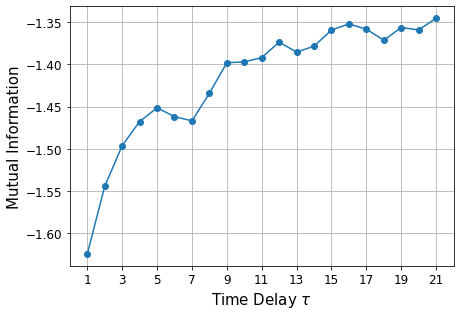

In [32]:
## Here we perform the mutual information calculation to determine the appropriate time delay.

datDelayInformation = []
for i in range(1,22):
    datDelayInformation = np.append(datDelayInformation,[mutualInformation(Gs_trial2[:,1],i,16)])

fig, ax = plt.subplots(figsize = (6.5,4.5))
plt.plot(range(1,22),datDelayInformation, 'o-');
plt.xlabel('Time Delay '+r'$\tau$', fontsize = 15);
plt.ylabel('Mutual Information', fontsize = 15);
plt.xticks(fontsize = 12)
ax.set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
plt.yticks(fontsize = 12)
plt.xlim(0,22)
plt.grid()
plt.tight_layout()
plt.show()

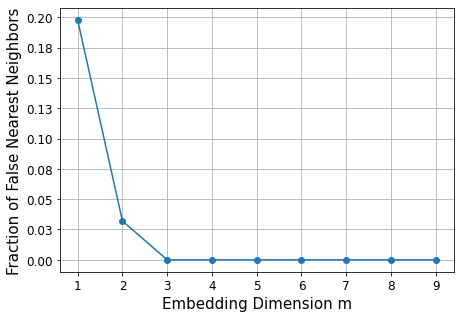

In [31]:
## Here we perform the flase nearest neighbors search to determine the appropriate embedding dimension.

nFNN = []
for i in range(1,10):
    nFNN.append(false_nearest_neighours(Gs_trial2[:,1],1,i) / len(Gs_trial2[:,1]))
    
fig, ax = plt.subplots(figsize = (6.5,4.5))    
plt.plot(range(1,10),nFNN, 'o-');
plt.xlabel('Embedding Dimension m', fontsize = 15);
plt.ylabel('Fraction of False Nearest Neighbors', fontsize = 15);
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.grid()
plt.tight_layout()
plt.show()

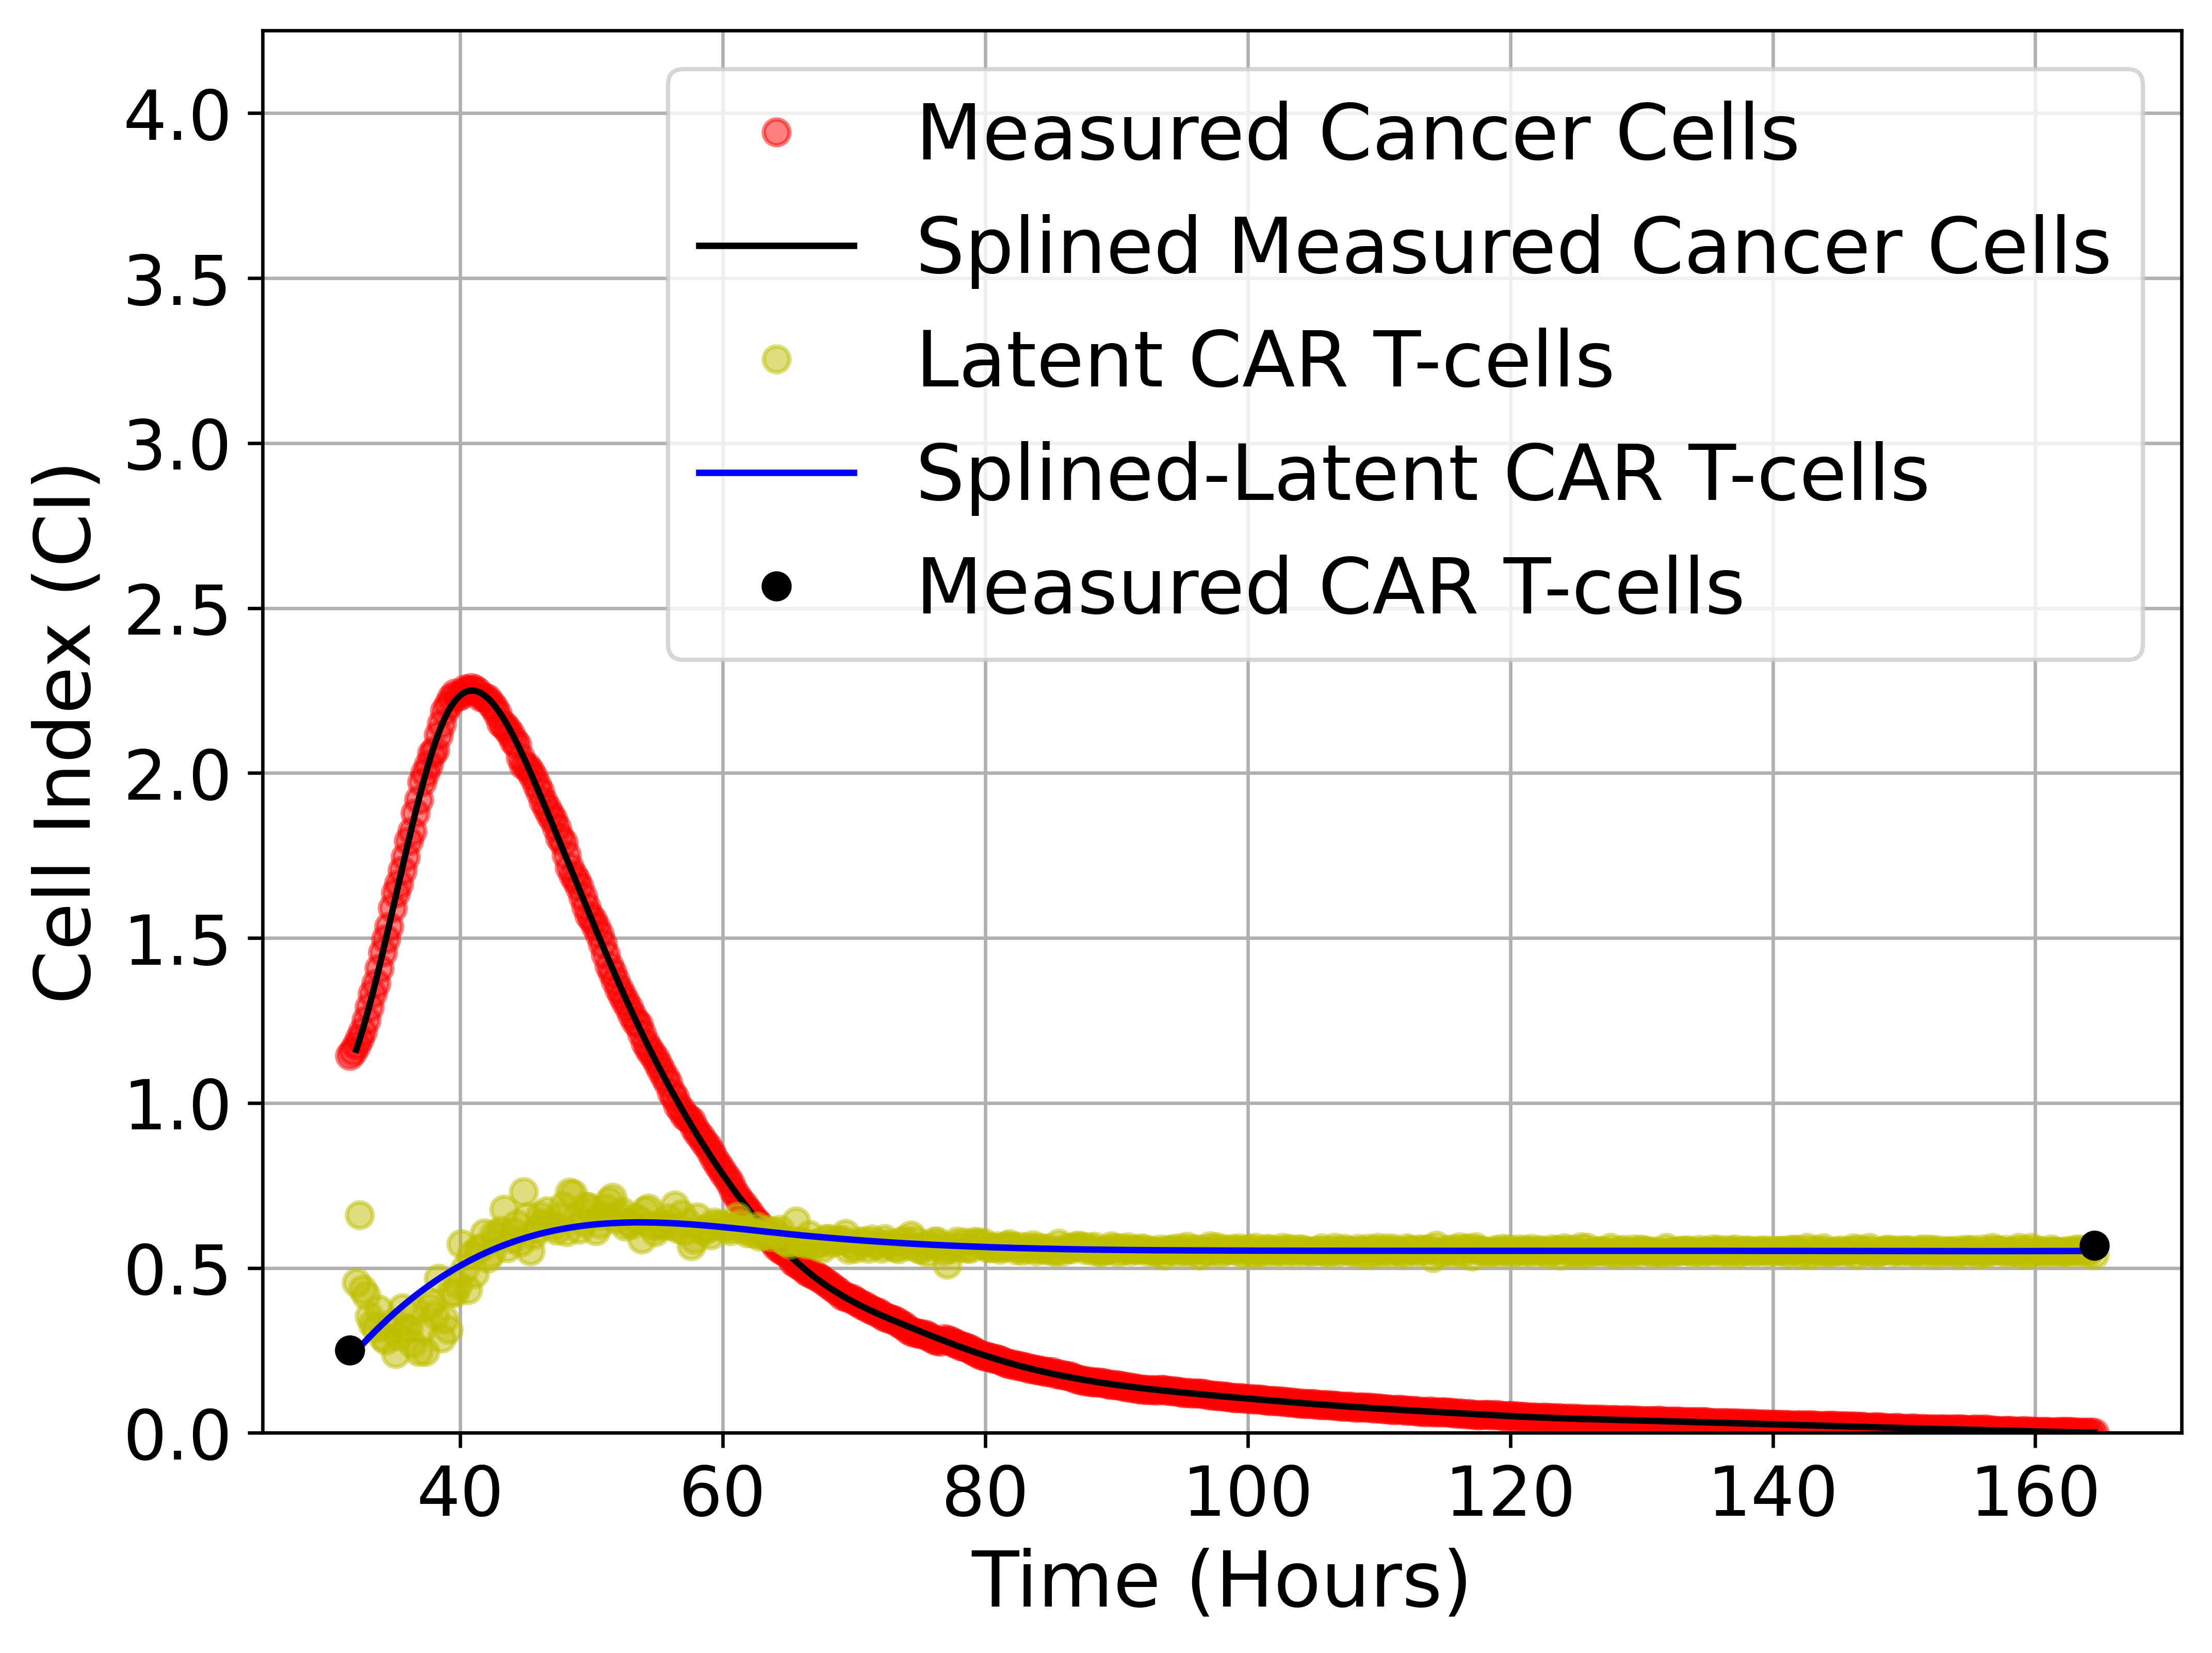

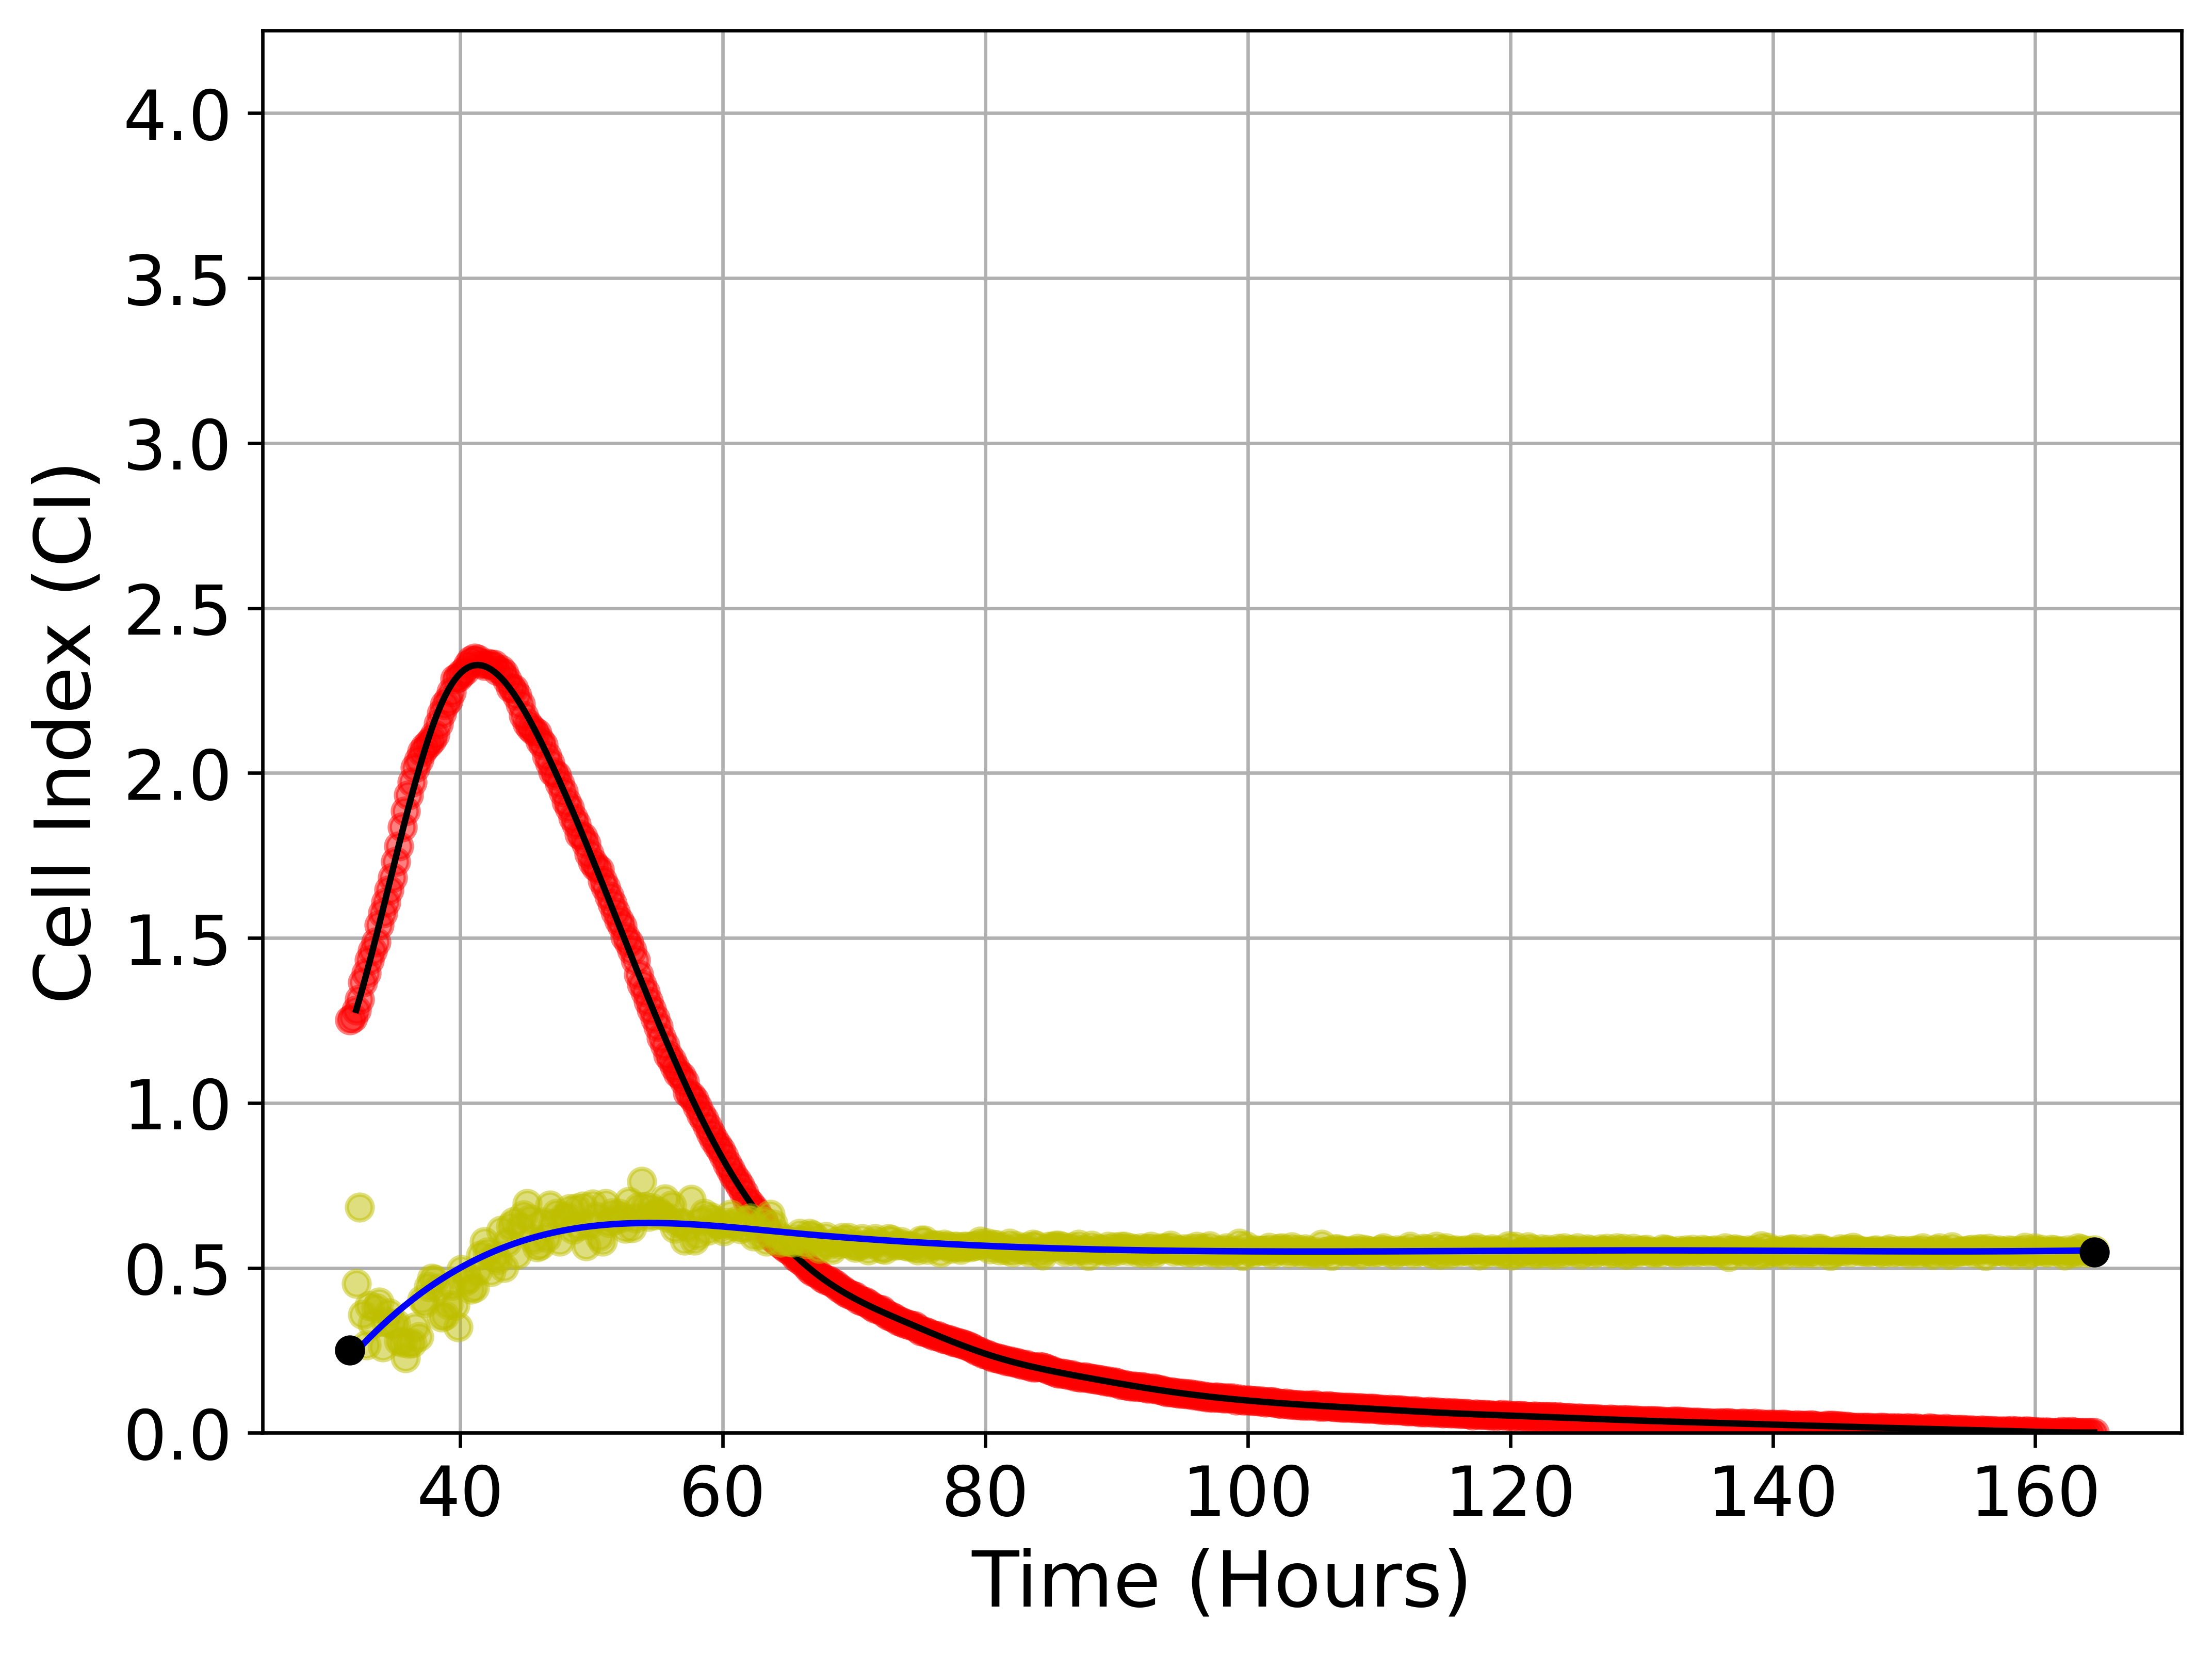

In [7]:
time, data = latent_discovery_spline(data_trajectories[:,0:,:], time_delay = 1, dimension = 2, nknots_arr = nknots_arr,
                                     t_cell_arr = t_cell_arr, invert_latent = invert_latent,
                                     cart_scale_arr = cart_scale_arr,
                                     cart_offset_arr = cart_offset_arr,
                                     save_fig = True, fig_name = ['pbt128_highET_trial1', 'pbt128_highET_trial2'])
#latent_discovery_spline(np.array([data_trial1]), nknots_arr = np.array([[10,10]]))

In [25]:
################################################################################
################ Implementing pySINDy with constraints #########################
################################################################################

### Here we implement the SINDy with constraints, and return to the pareto front 
### optimization approach.

differentiation_method = ps.SmoothedFiniteDifference(order = 3)
feature_library = ps.PolynomialLibrary(degree = 3, include_bias = False)
# the include_bias parameter toggles presence of constant terms in library.

feature_library.fit(data[0])

n_features = feature_library.n_output_features_
n_targets = data[0].shape[1]
print(f"Features ({n_features}):", feature_library.get_feature_names())
print(n_features)
print(n_targets)

Features (9): ['x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
9
2


In [26]:
# Set inequality constraints
eps = 1e-7

# constraints irrespective of growth rate in x and positive xy^2
constraint_rhs = np.array([eps, eps, eps, eps, eps, eps, eps, eps, eps,
                          eps, eps, eps, eps, eps, eps, eps, eps, eps, eps])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((19, n_targets * n_features))


## Zero out coefficients on y in xdot equation.
# 1 * (x1 coefficient) <= eps
constraint_lhs[0, 1] = 1

# 1 * (x1^2 coefficient) <= eps
constraint_lhs[1, 4] = 1

# 1 * (x1^3 coefficient) <= eps
constraint_lhs[2, 8] = 1

# -eps <= 1*(x1 coefficient)
constraint_lhs[3, 1] = -1

# -eps <= 1*(x1^2 coefficient)
constraint_lhs[4, 4] = -1

# -eps <= 1*(x1^3 coefficient)
constraint_lhs[5, 8] = -1

## Zero out coefficients on x in ydot equation.
# 1 * (x0 coefficient) <= eps
constraint_lhs[6, 9] = 1

# 1 * (x0^2 coefficient) <= eps
constraint_lhs[7, 11] = 1

# 1 * (x0^3 coefficient) <= eps
constraint_lhs[8, 14] = 1

# -eps <= 1*(x0 coefficient)
constraint_lhs[9, 9] = -1

# -eps <= 1*(x0^2 coefficient)
constraint_lhs[10, 11] = -1

# -eps <= 1*(x0^3 coefficient)
constraint_lhs[11, 14] = -1

# Force negativity of coeficient on xy^2 in xdot equation.
# 0 <= 1 * (x0x1^2 coefficient)
constraint_lhs[12, 7] = 1

# Force negativity of coeficient on xy^2 in ydot equation.
# 0 <= 1 * (x0 coefficient)
constraint_lhs[13, 16] = 1

## Zero out coefficients on x^2y in xdot equation.
# 1 * (x0 coefficient) <= eps
constraint_lhs[14, 6] = 1

# -eps <= 1*(x0 coefficient)
constraint_lhs[15, 6] = -1

## Force negativity of coeficient on x^3 in xdot equation.
# 0 >= 1 * (x0^3 coefficient)
constraint_lhs[16, 5] = 1

## Force negativity of coeficient on y^3 in ydot equation.
# 0 >= 1 * (x1^3 coefficient)
constraint_lhs[17, 17] = 1

## Force negativity of coeficient on xy in xdot equation.
# 0 >= 1 * (x0x1 coefficient)
constraint_lhs[18, 3] = 1

# Define the optimizer to be used and associated optimization parameters
# Run a single instance of SINDy to see it works.
optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,
    thresholder="l1",
    tol=1e-5,
    threshold=5e-1,
    max_iter=10000
)
model = ps.SINDy(optimizer=optimizer,
                 feature_library=feature_library,
                feature_names = ["x", "y"],
                differentiation_method = differentiation_method)

model.fit(data, t = time, multiple_trajectories = True)

model.print()
model.coefficients()

(x)' = 0.112 x + 0.040 x^2 + -0.010 x^3 + -0.538 x y^2
(y)' = -0.002 y^2 + 0.007 x^2 y


array([[ 1.12362351e-01, -3.47684724e-08,  4.03359115e-02,
         3.61712750e-08, -3.41147815e-08, -9.62327105e-03,
        -1.50045224e-11, -5.37533184e-01, -3.37584186e-08],
       [ 4.48001624e-07,  9.12705519e-07,  6.49226101e-07,
        -1.76252541e-07, -1.66824304e-03,  5.82650605e-07,
         6.89947220e-03, -1.35692768e-07,  1.26640168e-07]])

In [27]:
### Perform pareto front analysis and loop through many values of threshold 
### to identify parsimonious model.

num_terms = []

## This spread was used for all figures but histograms of coefficients.  There are 36 values in this list.
threshold_vals = [1e-8, 2.5e-8, 5e-8, 7.5e-8, 1e-7, 2.5e-7, 5e-7, 7.5e-7, 
                 1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5, 2.5e-5, 5e-5, 7.5e-5, 
                 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 
                 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 
                 1e0, 2.5e0, 5e0, 7.5e0]

## This spread is used for histograms of coefficients.  There are 1000 values in this list.
#threshold_vals = np.linspace(0.5e-2, 1e1, 1000)
models = []
coefs = []

for i in range(0, 36):
    
    optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,
    thresholder="l1",
    tol=1e-5,
    threshold=threshold_vals[i],
    max_iter=10000)
#    print(threshold_vals[i])
    
    models.append(ps.SINDy(optimizer=optimizer,
                 feature_library=feature_library,
                feature_names = ["x", "y"],
                differentiation_method = differentiation_method))

    
    models[i].fit(data, t = time, multiple_trajectories = True)
    num_terms.append(sum(abs(models[i].coefficients())>=1e-3))
    coefs.append(models[i].coefficients())
    
print(num_terms)

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 8, 8, 6, 6, 5, 5, 4, 3, 3]


In [28]:
## Testing with calculating mean squared error 
## Here, score is calculated based on estimates/predictions of the time derivatives

score = []
deriv_score = []
for i in range(0,len(threshold_vals)):
    deriv_score.append(models[i].score(data, t=time, 
                                  metric = mean_squared_error, multiple_trajectories = True))
    pred_rmse = 0

    for j in range(0,len(data)):
        num_data_points = data[j].shape[0]*data[j].shape[1]
        prediction = models[i].simulate(data[j][0,:], time[j], integrator = 'odeint')
        pred_rmse = pred_rmse + np.sqrt(np.sum(np.square(prediction - data[j]))/num_data_points)
    score.append(pred_rmse/len(data))


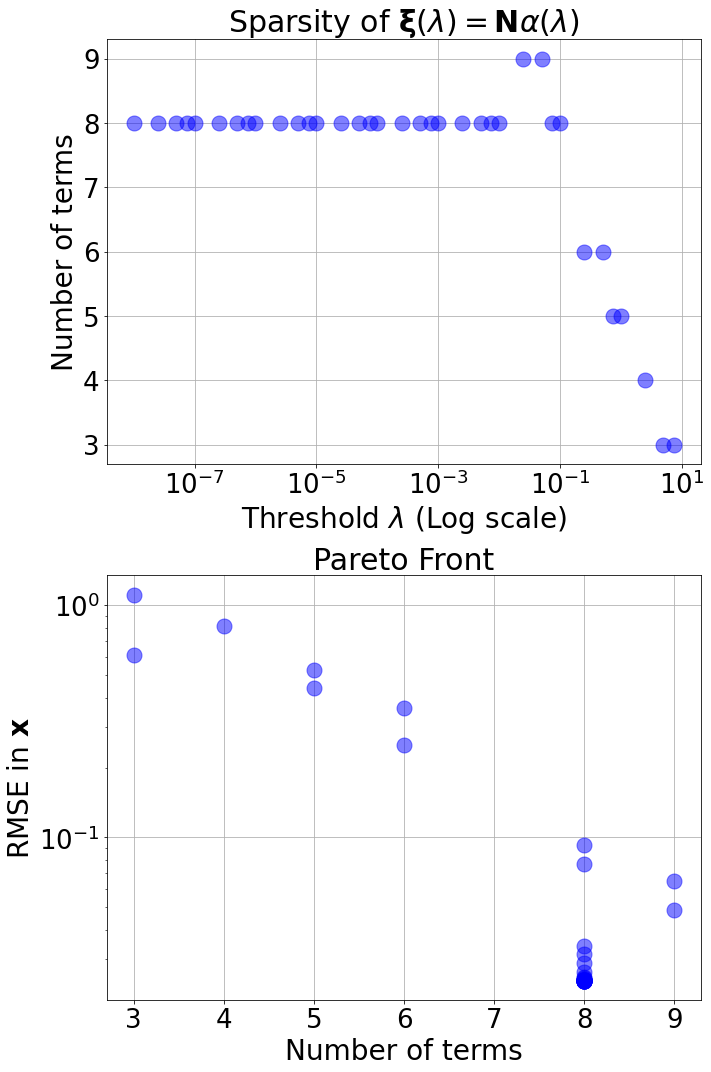

In [29]:
###  Graphing pareto fronts for active library terms

plt.figure(figsize = (10,15))

ax1 = plt.subplot(2,1,1)
plt.semilogx(threshold_vals, num_terms, "bo", markersize = 15, alpha = 0.5)
plt.title(r'Sparsity of $\mathbf{\xi}(\lambda) = {\bfN}\alpha(\lambda)$', fontsize = 30)
plt.xlabel(r'Threshold $\lambda$ (Log scale)', fontsize = 28)
plt.ylabel('Number of terms', fontsize = 28)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.grid(True)
#plt.semilogx(threshold_vals, score, "b")

ax2 = plt.subplot(2,1,2)
plt.semilogy(num_terms, score, "bo", markersize = 15, alpha = 0.5)
#plt.ylim((1e0, 1e9))
plt.title('Pareto Front', fontsize = 30)
plt.ylabel(r'RMSE in $\mathbf{x}$', fontsize = 28)
plt.xlabel('Number of terms', fontsize = 28)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.grid(True)

plt.tight_layout()
#plt.savefig(fname='/Users/abrummer/Desktop/pbt128_lowET_pareto_front.png', dpi = 300,
#                    bbox_inches = 'tight')
plt.show()

In [30]:
# high E:T is 0 when constraining x^2y and x^3.  RMSE should read 0.02423
# medium E:T is 21 when constraining x^2y
# medium E:T is 13 when constraining x^2y and x^3.  RMSE should read 0.1946
# low E:T is 21, 3 when constraining x^2y, 18 with epsilon set to 1e-10
#    for tighter bounds on zero values.
# low E:T is 22 when constraining x^2y and x^3.  RMSE should read 0.3594


print(num_terms.index(8))
print(num_terms[0])
print(score[0])

0
8
0.0242259457996088


In [31]:
models[0].print()
models[0].coefficients()

(x)' = 0.121 x + 0.061 x^2 + -0.018 x^3 + -0.593 x y^2
(y)' = 0.191 y + 0.035 x y + -0.351 y^2 + -0.009 x^2 y


array([[ 1.20546152e-01,  2.27475316e-05,  6.08658713e-02,
         1.04612841e-07,  1.24583201e-05, -1.76485476e-02,
         6.13418381e-08, -5.93393522e-01,  6.83423474e-06],
       [-1.75248788e-14,  1.91000765e-01, -9.99999911e-08,
         3.46652047e-02, -3.50780876e-01, -9.99999998e-08,
        -8.64664584e-03,  9.99999908e-08,  1.00000002e-07]])

In [32]:
forward_time = [np.array(np.linspace(time[0][0], 1.5*time[0][-1], 3*len(time[0]))),
               np.array(np.linspace(time[1][0], 1.5*time[1][-1], 3*len(time[1]))),
               np.array(np.linspace(time[1][0], 1.5*time[1][-1], 3*len(time[1])))]
print(forward_time)

[array([ 32.086667  ,  32.22175143,  32.35683587, ..., 246.46566513,
       246.60074957, 246.735834  ]), array([ 32.086667  ,  32.22175143,  32.35683587, ..., 246.46566513,
       246.60074957, 246.735834  ]), array([ 32.086667  ,  32.22175143,  32.35683587, ..., 246.46566513,
       246.60074957, 246.735834  ])]


In [33]:
# high E:T is 22
# medium E:T is 26
# low E:T is 22

model_num = 0
x_test_sim_arr = []
x_forward_sim_arr = []
pred_rmse = []


for i in range(0,len(data)):
    x_test_sim_arr.append(models[model_num].simulate(data[i][0,:], time[i],
                                    integrator = 'odeint'))
    x_forward_sim_arr.append(models[model_num].simulate(data[i][0,:], forward_time[i],
                                    integrator = 'odeint'))
    num_data_points = data[i].shape[0]*data[i].shape[1]
    pred_rmse = np.sqrt(np.sum(np.square(x_test_sim_arr[i] - data[i]))/num_data_points)

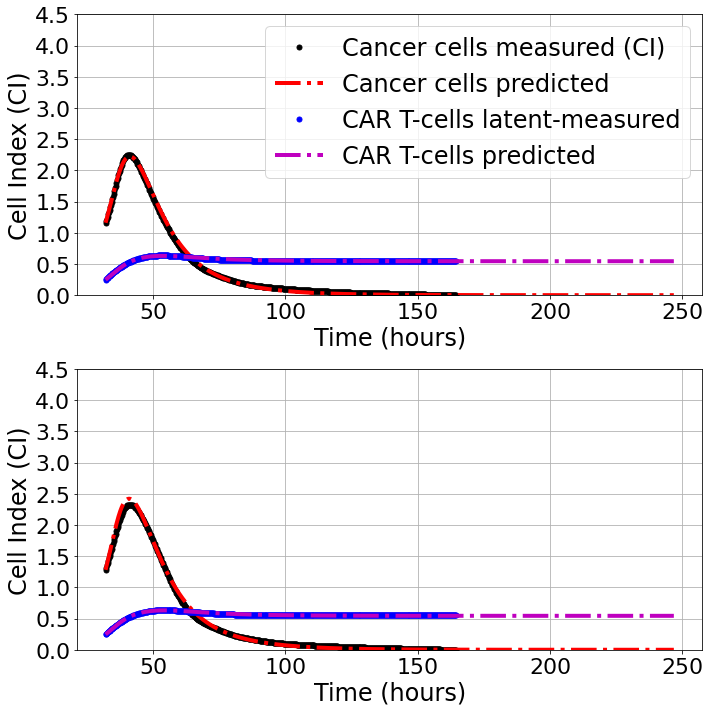

In [38]:
### Plot a stack of the two trials using the given model.

plt.figure(figsize = (10,10))
ax1 = plt.subplot(2,1,1)
plt.plot(time[0], data[0][:,0],
        'k.', label = 'Cancer cells measured (CI)', markersize = 10)
plt.plot(forward_time[0], x_forward_sim_arr[0][:,0],
         'r-.', label = 'Cancer cells predicted', linewidth = 4)
plt.plot(time[0], data[0][:,1],
        'b.', label = 'CAR T-cells latent-measured', markersize = 10)
plt.plot(forward_time[0], x_forward_sim_arr[0][:,1],
        'm-.', label = 'CAR T-cells predicted', linewidth = 4)
plt.xlabel('Time (hours)', fontsize = 24)
plt.ylabel('Cell Index (CI)', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.ylim(0,4.5)
#plt.title()
plt.grid(True)
plt.legend(fontsize = 24, loc = 'upper right')

ax2 = plt.subplot(2,1,2)
plt.plot(time[1], data[1][:,0],
        'k.', label = 'Cancer cells measured (CI)', markersize = 10)
plt.plot(forward_time[1], x_forward_sim_arr[1][:,0],
         'r-.', label = 'Cancer cells predicted', linewidth = 4)
plt.plot(time[1], data[1][:,1],
        'b.', label = 'CAR T-cells latent-measured', markersize = 10)
plt.plot(forward_time[1], x_forward_sim_arr[1][:,1],
        'm-.', label = 'CAR T-cells predicted', linewidth = 4)
plt.xlabel('Time (hours)', fontsize = 24)
plt.ylabel('Cell Index (CI)', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.ylim(0,4.5)
#plt.title()
plt.grid(True)
#plt.legend(fontsize = 14, loc = 'center right')

plt.tight_layout()
# plt.savefig(fname='/Users/alexwork/Desktop/pbt128_highET_simulated_forward_dbl_bind_and_expand_constraint.png', dpi = 300,
#                    bbox_inches = 'tight')
plt.show()

In [336]:
coeffs_array = np.zeros([1000, 2,9])

In [340]:
for i in range(0,len(models)):
    coeffs_array[i,:,:] = models[i].coefficients()
feature_names = ['x', 'y']
min_overall = -0.6
max_overall = 0.2
xticknames = models[0].get_feature_names()

In [341]:
coeffs_array

array([[[ 1.50199740e-01,  8.10733202e-15, -1.20936720e-02, ...,
          9.99999991e-08,  3.33333638e-08,  2.83739730e-15],
        [ 2.86245144e-06,  1.08801968e-07,  6.79971399e-06, ...,
          5.44263909e-03, -6.32354777e-02,  1.02688766e-07]],

       [[ 1.50057078e-01, -6.20334828e-14, -1.20846447e-02, ...,
          1.00000007e-07,  3.33333414e-08, -2.92177575e-15],
        [ 5.65041403e-06,  6.75547107e-08,  5.92703322e-06, ...,
          5.30199673e-03, -5.07455423e-02, -2.53536329e-08]],

       [[ 1.49914417e-01,  7.27099648e-14, -1.20756173e-02, ...,
          9.99999934e-08,  3.33333190e-08,  8.86910521e-17],
        [ 1.31298027e-05,  1.69021311e-07,  1.48220876e-05, ...,
          4.93589692e-03, -3.56182461e-02, -7.30322563e-08]],

       ...,

       [[ 1.27404762e-02, -3.33333394e-08,  7.85229444e-14, ...,
         -4.70781535e-08, -1.72542808e-15, -3.33333336e-08],
        [ 2.76910243e-06,  3.58403157e-07,  4.03234088e-06, ...,
          3.41847487e-06,  1.84148

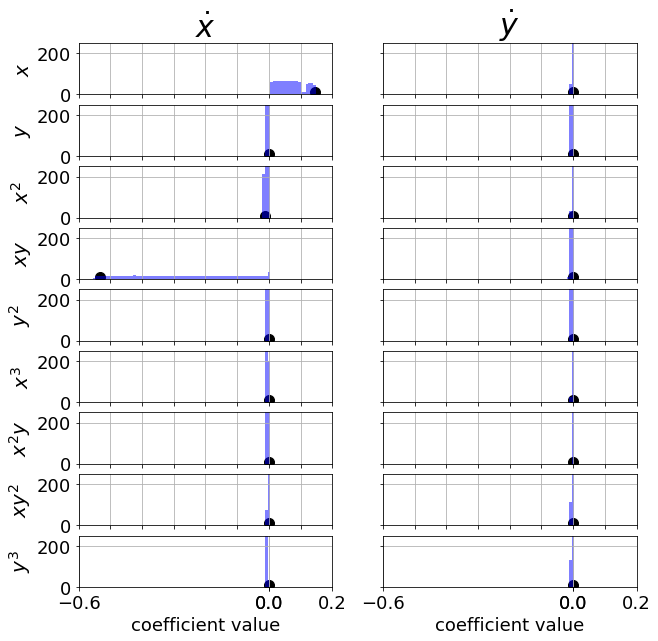

In [343]:
# Loop through each element in the coefficients

plt.figure(figsize = (10,10))
for j in range(9):
    for i in range(2):
        plt.subplot(9, 2, i + 1 + j * 2)
        if j == 0:
            plt.title('$\dot{'+feature_names[i]+'}$', fontsize=30)
        bins = np.linspace(min_overall, max_overall, 101)
        plt.hist(coeffs_array[:, i, j], color='b', bins=bins,
                 label='ensemble', align='left', alpha = 0.5)
#       plt.hist(library_ensemble_coefs[:, i, j], bins=bins,
#                 color='r', alpha=0.5, label='library ensemble', align='left')
        plt.scatter(models[21].coefficients()[i, j], 10, color='k',
                    label='true value', s=100, marker='o')
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel('$'+xticknames[j]+'$', fontsize=20)
#            plt.xlim(-1,1)
        else:
            ax.set_yticklabels([])
        if j != 8:
            ax.set_xticklabels([])
        else:
            plt.xlabel('coefficient value', fontsize=18)
            ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        plt.ylim(0, 250)
        plt.xlim(min_overall, max_overall)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if i == 1 and j == 9:
            plt.legend(fontsize=16)
#plt.savefig(fname='/Users/abrummer/Desktop/pbt128_lowET_coeff_bins.png', dpi = 300,
#                    bbox_inches = 'tight')

# References

#### [1] Brummer, A.B.; Yang, X.; Ma, E.; Gutova, M.; Brown, C.E.; Rockne, R.C. Dose-dependent thresholds of 
####     dexamethasone destabilize CAR T-cell treatment efficacy. PLOS Computational Biology 2022, 18, e1009504.
#### [2] Tigurius. (May, 2018). Introduction to Taken's Embedding. Version 6. Last Retrieved October 4, 2022 from 
####     https://www.kaggle.com/code/tigurius/introduction-to-taken-s-embedding
#### [3] de Silva, B.M.; Champion, K.; Quade, M.; Loiseau, J.C.; Kutz, J.N.; Brunton, S.L. PySINDy: A Python package 
####     for the sparse identification of nonlinear dynamical systems from data. Journal of Open Source Software 
####     2020, 5, 2104. https://doi.org/10.21105/joss.02104.
#### [4] Kaptanoglu, A.A.; de Silva, B.M.; Fasel, U.; Kaheman, K.; Goldschmidt, A.J.; Callaham, J.; Delahunt, C.B.; 
####     Nicolaou, Z.G.; Champion, K.; Loiseau, J.C.; et al. PySINDy: A comprehensive Python package for robust 
####     sparse system identification. Journal of Open Source Software 2022, 7, 3994. 
####     https://doi.org/10.21105/joss.03994.

